# SageMaker: deploy models in shadow mode

Relevant links:
1. [SageMaker documentation](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-shadow-variant/Shadow_variant.html): this notebook is a copy-paste from this documentation with minor changes
2. [Semantic Segmantion with Hugging Face's Transformers & Amazon SageMaker by Philipp Schmid](https://www.philschmid.de/image-segmentation-sagemaker)

In [1]:
# !pip install segmentation-mask-overlay
#!pip install sagemaker --upgrade

### Imports + setting up AWS-related objects

In [1]:
import os
import boto3
import sagemaker
import time
from time import gmtime, strftime
from datetime import datetime, timedelta, timezone
from sagemaker import session
from sagemaker.s3 import S3Downloader, S3Uploader


region = "eu-west-1"
os.environ["AWS_DEFAULT_REGION"] = region
role = "arn:aws:iam::257446244580:role/sagemaker-icevision"
sm_session = sagemaker.Session(boto_session=boto3.Session(region_name=region))
sm_runtime = boto3.Session().client("sagemaker-runtime", region_name=region)
sm = boto3.Session().client("sagemaker", region_name=region)

### Retrieving HuggingFace Docker image URI from ECR

In [ ]:
from sagemaker import image_uris
image_uris.config_for_framework(framework="huggingface")

In [2]:
from sagemaker import image_uris

image_uri = image_uris.retrieve(framework="huggingface", 
                    region=region, 
                    version="4.17", 
                    image_scope="inference",
                    py_version="py38", 
                    instance_type="ml.g4dn.xlarge",
                    base_framework_version="pytorch1.10"
                    )
image_uri

'763104351884.dkr.ecr.eu-west-1.amazonaws.com/huggingface-pytorch-inference:1.10-transformers4.17-gpu-py38-cu113-ubuntu20.04'

### Creating production and shadow models

* Production model: NVIDIA [SegFormer](https://arxiv.org/abs/2105.15203), [link to HuggingFace Hub](https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512)
* Shadow model: Microsoft [BEiT](https://www.microsoft.com/en-us/research/publication/beit-bert-pre-training-of-image-transformers/), [link to HuggingFace Hub](https://huggingface.co/microsoft/beit-base-finetuned-ade-640-640)

In [3]:
model_name1 = "PROD-nvidia-segformer"
model_name2 = "SHADOW-microsoft-beit"

print(f"Prod model name: {model_name1}")
print(f"Shadow model name: {model_name2}")

resp = sm.create_model(
    ModelName=model_name1,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri, 
                "Environment": { 
                   'HF_MODEL_ID':'nvidia/segformer-b0-finetuned-ade-512-512',
                   'HF_TASK':'image-segmentation' 
                                },}],
)
print(f"Created prod model: {resp}")

resp = sm.create_model(
    ModelName=model_name2,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri, 
                "Environment": { 
                    'HF_MODEL_ID':'microsoft/beit-base-finetuned-ade-640-640',
                    'HF_TASK':'image-segmentation' 
                                },}],
)
print(f"Created shadow model: {resp}")

Prod model name: PROD-nvidia-segformer
Shadow model name: SHADOW-microsoft-beit
Created prod model: {'ModelArn': 'arn:aws:sagemaker:eu-west-1:257446244580:model/prod-nvidia-segformer', 'ResponseMetadata': {'RequestId': 'df35450c-dfa6-49fa-97bb-3df7df3cfc77', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'df35450c-dfa6-49fa-97bb-3df7df3cfc77', 'content-type': 'application/x-amz-json-1.1', 'content-length': '83', 'date': 'Tue, 27 Dec 2022 17:51:10 GMT'}, 'RetryAttempts': 0}}
Created shadow model: {'ModelArn': 'arn:aws:sagemaker:eu-west-1:257446244580:model/shadow-microsoft-beit', 'ResponseMetadata': {'RequestId': 'fe5b1729-0fc9-4d57-bb5e-878e741e7225', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'fe5b1729-0fc9-4d57-bb5e-878e741e7225', 'content-type': 'application/x-amz-json-1.1', 'content-length': '83', 'date': 'Tue, 27 Dec 2022 17:51:12 GMT'}, 'RetryAttempts': 2}}


### Defining the endpoint config, with the production and shadow variants

In [4]:
ep_config_name = "shadow-hf-epconfig"
production_variant_name = model_name1
shadow_variant_name = model_name2

create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name,
    ProductionVariants=[
        {
            "VariantName": production_variant_name,
            "ModelName": model_name1,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
        }
    ],
    ShadowProductionVariants=[
        {
            "VariantName": shadow_variant_name,
            "ModelName": model_name2,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
        }
    ],
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

Created EndpointConfig: arn:aws:sagemaker:eu-west-1:257446244580:endpoint-config/shadow-hf-epconfig


### Deploying the endpoint

In [5]:
endpoint_name = "shadow-hf"
create_endpoint_api_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name,
)

In [6]:
def wait_for_endpoint_in_service(endpoint_name):
    print("Waiting for endpoint in service")
    while True:
        details = sm.describe_endpoint(EndpointName=endpoint_name)
        status = details["EndpointStatus"]
        if status in ["InService", "Failed"]:
            print("\nDone!")
            break
        print(".", end="", flush=True)
        time.sleep(30)


wait_for_endpoint_in_service(endpoint_name)

sm.describe_endpoint(EndpointName=endpoint_name)

Waiting for endpoint in service
..........
Done!


{'EndpointName': 'shadow-hf',
 'EndpointArn': 'arn:aws:sagemaker:eu-west-1:257446244580:endpoint/shadow-hf',
 'EndpointConfigName': 'shadow-hf-epconfig',
 'ProductionVariants': [{'VariantName': 'PROD-nvidia-segformer',
   'DeployedImages': [{'SpecifiedImage': '763104351884.dkr.ecr.eu-west-1.amazonaws.com/huggingface-pytorch-inference:1.10-transformers4.17-gpu-py38-cu113-ubuntu20.04',
     'ResolvedImage': '763104351884.dkr.ecr.eu-west-1.amazonaws.com/huggingface-pytorch-inference@sha256:17e776fd3295cc6dfee4e122618f5bab7ef04e87ed0490ce6b64722a60f03333',
     'ResolutionTime': datetime.datetime(2022, 12, 27, 17, 51, 20, 153000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2022, 12, 27, 17, 51, 19, 516000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2022, 12, 27, 17, 56, 7, 952000, tzinfo=tzlocal()),
 'ShadowProductionVari

### Inference on the endpoint

In [8]:
!wget https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/raw/main/ADE_val_00000001.jpg

--2022-12-27 17:56:37--  https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/raw/main/ADE_val_00000001.jpg
Resolving huggingface.co (huggingface.co)... 34.238.87.3, 18.235.116.140, 34.202.56.10, ...
Connecting to huggingface.co (huggingface.co)|34.238.87.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52650 (51K) [image/jpeg]
Saving to: ‘ADE_val_00000001.jpg’

ADE_val_00000001.jp 100%[===================>]  51.42K  --.-KB/s    in 0.07s   

2022-12-27 17:56:38 (791 KB/s) - ‘ADE_val_00000001.jpg’ saved [52650/52650]



In [2]:
model_name1 = "PROD-nvidia-segformer"
model_name2 = "SHADOW-microsoft-beit"
production_variant_name = model_name1
shadow_variant_name = model_name2
ep_config_name = "shadow-hf-epconfig"
endpoint_name = "shadow-hf"

In [9]:
image_path = "ADE_val_00000001.jpg"

with open(image_path, "rb") as f:
    payload = f.read()
    payload = bytearray(payload)

response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                      ContentType="image/x-image", 
                                      Body=payload)
response

{'ResponseMetadata': {'RequestId': '77dda78a-755d-4d2f-a895-ba4402b380ab',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '77dda78a-755d-4d2f-a895-ba4402b380ab',
   'x-amzn-invoked-production-variant': 'PROD-nvidia-segformer',
   'date': 'Tue, 27 Dec 2022 17:56:42 GMT',
   'content-type': 'application/json',
   'content-length': '15135'},
  'RetryAttempts': 0},
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'PROD-nvidia-segformer',
 'Body': <botocore.response.StreamingBody at 0x7fcac3ca4e80>}

dict_keys(['score', 'label', 'mask'])


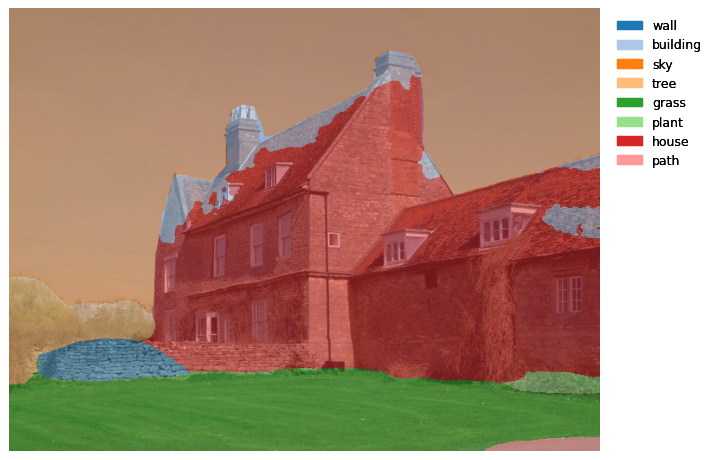

In [10]:
from PIL import Image
import io
from segmentation_mask_overlay import overlay_masks
import numpy as np
import base64
import matplotlib.pyplot as plt
import json


def stringToRGB(base64_string):
    # convert base64 string to numpy array
    imgdata = base64.b64decode(str(base64_string))
    image = Image.open(io.BytesIO(imgdata))
    return np.array(image)

def get_overlay(original_image_path,result):
    masks = [stringToRGB(r["mask"]).astype('bool') for r in result]
    masks_labels = [r["label"] for r in result]
    cmap = plt.cm.tab20(np.arange(len(masks_labels)))

    image = Image.open(original_image_path)
    overlay_masks(image, masks, labels=masks_labels, colors=cmap, mask_alpha=0.5)


image_path = "ADE_val_00000001.jpg"

with open(image_path, "rb") as data_file:
  image_data = data_file.read()
  res = json.loads(response["Body"].read().decode("utf-8"))
  print(res[0].keys())
  get_overlay(image_path,res)


### Invoking the endpoint repeatedly to create logs in CloudWatch

In [10]:
import random
import time

def invoke_endpoint(endpoint_name, should_raise_exp=False):
    with open(image_path, "rb") as f:
        payload = f.read()
        payload = bytearray(payload)
        try:
            for i in range(200):
                time.sleep(random.uniform(0, 1) * 3)
                response = sm_runtime.invoke_endpoint(
                    EndpointName=endpoint_name, ContentType="image/x-image", Body=payload
                )
        except Exception as e:
            print("E", end="", flush=True)
            if should_raise_exp:
                raise e


invoke_endpoint(endpoint_name)

### Plot metrics from CloudWatch comparing production and shadow variants

In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

cw = boto3.Session().client("cloudwatch", region_name=region)

def get_sagemaker_metrics(
    endpoint_name,
    variant_name,
    metric_name,
    statistic,
    start_time,
    end_time,
):
    dimensions = [
        {"Name": "EndpointName", "Value": endpoint_name},
        {"Name": "VariantName", "Value": variant_name},
    ]
    namespace = "AWS/SageMaker"
    if metric_name in ["CPUUtilization", "MemoryUtilization", "DiskUtilization"]:
        namespace = "/aws/sagemaker/Endpoints"

    metrics = cw.get_metric_statistics(
        Namespace=namespace,
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=1,
        Statistics=[statistic],
        Dimensions=dimensions,
    )

    if len(metrics["Datapoints"]) == 0:
        return
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop(["Unit"], axis=1)
        .rename(columns={statistic: variant_name})
    )


def plot_endpoint_invocation_metrics(
    endpoint_name,
    metric_name,
    statistic,
    start_time=None,
):
    start_time = start_time or datetime.now(timezone.utc) - timedelta(minutes=10)
    end_time = datetime.now(timezone.utc)
    metrics_production = get_sagemaker_metrics(
        endpoint_name,
        production_variant_name,
        metric_name,
        statistic,
        start_time,
        end_time,
    )
    metrics_shadow = get_sagemaker_metrics(
        endpoint_name,
        shadow_variant_name,
        metric_name,
        statistic,
        start_time,
        end_time,
    )
    try:
        metrics_variants = pd.merge(metrics_production, metrics_shadow, on="Timestamp").reset_index()
        metrics_variants = metrics_variants.melt('Timestamp', var_name='Variant', value_name=metric_name)
        plt.figure(figsize=(13,7))
        return sns.lineplot(data=metrics_variants, x="Timestamp", y=metric_name, hue="Variant")
    except Exception as e:
        print(e)

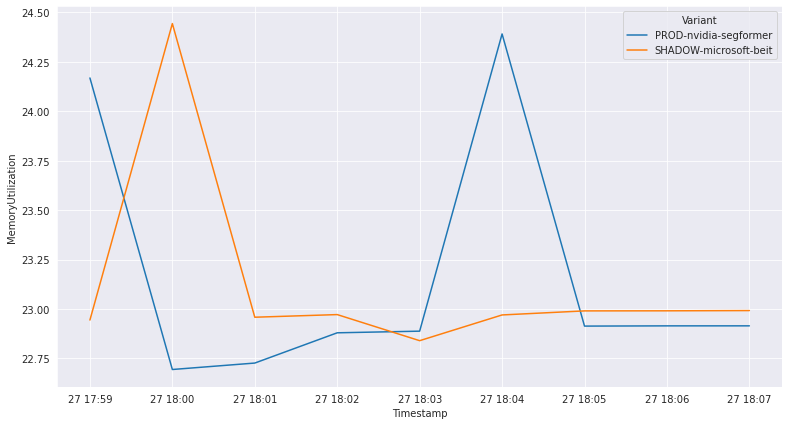

In [25]:
invocations = plot_endpoint_invocation_metrics(endpoint_name, "MemoryUtilization", "Average")

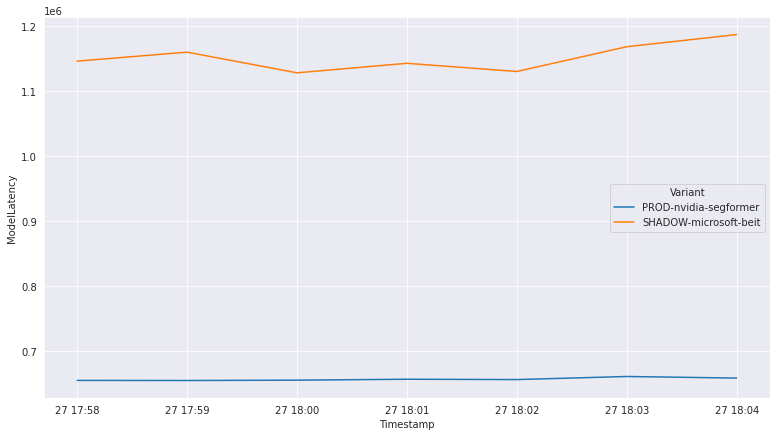

In [21]:
model_latency = plot_endpoint_invocation_metrics(endpoint_name, "ModelLatency", "Average")

### Clean up AWS resources

In [16]:
sm.delete_model(ModelName=model_name1)
sm.delete_model(ModelName=model_name2)
sm.delete_endpoint_config(EndpointConfigName=ep_config_name)
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '1d82dd59-aa23-4b60-b4c7-9da3ffc9740a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '1d82dd59-aa23-4b60-b4c7-9da3ffc9740a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 23 Dec 2022 21:30:21 GMT'},
  'RetryAttempts': 0}}